<a href="https://colab.research.google.com/github/Raoufmamedov/Xperiments/blob/main/multiboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Запуск процесса 3 с параметрами: {'n_estimators': 100, 'learning_rate': 0.12, 'max_depth': 4, 'random_state': 3, 'subsample': 0.72}Запуск процесса 0 с параметрами: {'n_estimators': 100, 'learning_rate': 0.13, 'max_depth': 3, 'random_state': 0, 'subsample': 0.93}Запуск процесса 1 с параметрами: {'n_estimators': 100, 'learning_rate': 0.14, 'max_depth': 4, 'random_state': 1, 'subsample': 0.83}
Запуск процесса 2 с параметрами: {'n_estimators': 100, 'learning_rate': 0.12, 'max_depth': 4, 'random_state': 2, 'subsample': 0.99}


Запуск процесса 4 с параметрами: {'n_estimators': 100, 'learning_rate': 0.07, 'max_depth': 5, 'random_state': 4, 'subsample': 0.96}
Процесс 1 завершен. Финальная ошибка на тесте: 8.9004
Процесс 0 завершен. Финальная ошибка на тесте: 9.7639
Процесс 3 завершен. Финальная ошибка на тесте: 8.4233
Процесс 4 завершен. Финальная ошибка на тесте: 8.8824
Процесс 2 завершен. Финальная ошибка на тесте: 9.3382

Все процессы завершены. Анализ результатов:


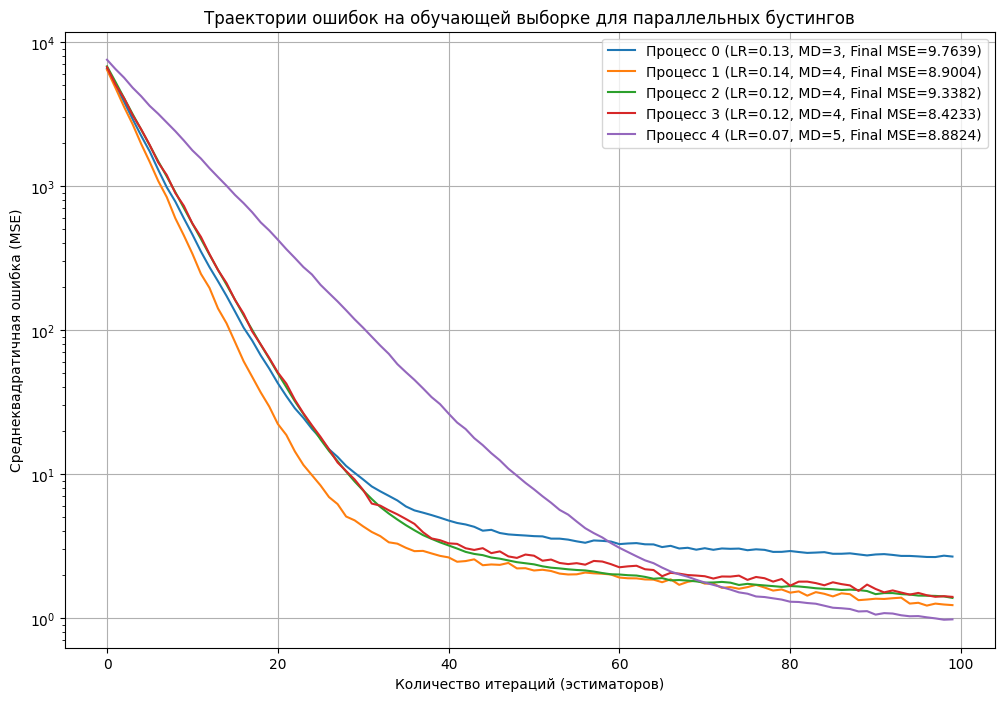


Лучший процесс по MSE на тестовой выборке: Процесс 3 с MSE = 8.4233
Параметры лучшей модели: {'n_estimators': 100, 'learning_rate': 0.12, 'max_depth': 4, 'random_state': 3, 'subsample': 0.72}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import multiprocessing # Для параллельного выполнения
import random # Для случайных начальных условий

# 1. Генерация синтетических данных для примера
np.random.seed(42)
X = np.random.rand(1000, 5) * 10 # 1000 образцов, 5 признаков
y = 2 * X[:, 0] + 3 * X[:, 1]**2 - 0.5 * X[:, 2] + np.random.randn(1000) * 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---

## Функция для запуска одного бустинга и сбора метрик


def run_boosting_process(process_id, X_train, y_train, X_test, y_test, params):
    """
    Функция для запуска одного процесса бустинга и сбора метрик.
    """
    print(f"Запуск процесса {process_id} с параметрами: {params}")

    # Инициализация модели бустинга
    # Используем GradientBoostingRegressor как пример.
    # Для XGBoost/LightGBM логика будет похожей, но с их API.
    gbr = GradientBoostingRegressor(
        n_estimators=params.get('n_estimators', 100),
        learning_rate=params.get('learning_rate', 0.1),
        max_depth=params.get('max_depth', 3),
        random_state=params.get('random_state', None),
        # Дополнительные параметры, например, subsample для большей вариативности
        subsample=params.get('subsample', 1.0)
    )

    # Список для хранения значений objective (MSE) на каждой итерации
    train_errors = []
    test_errors = []

    # "Ручной" бустинг для отслеживания ошибок на каждой итерации
    # scikit-learn GradientBoostingRegressor не предоставляет прямого доступа
    # к ошибке на каждой итерации, как XGBoost.
    # Поэтому мы будем обучать его пошагово для демонстрации.
    # В реальном коде, если вы используете XGBoost/LightGBM,
    # используйте их callback-функции или `evals_result`.

    # Для демонстрации, обучим модель и соберем ошибки
    gbr.fit(X_train, y_train)
    # Эти атрибуты становятся доступны после fit
    train_errors = list(gbr.train_score_) # Ошибка на обучающей выборке на каждой итерации
    # Для тестовой выборки нужно будет предсказывать на каждой итерации,
    # что GradientBoostingRegressor не делает автоматически для test_score_.
    # Если это критично, лучше использовать XGBoost или LightGBM с eval_set.
    # Для простоты, здесь мы просто вычислим финальную ошибку на тесте.
    test_error_final = mean_squared_error(y_test, gbr.predict(X_test))
    print(f"Процесс {process_id} завершен. Финальная ошибка на тесте: {test_error_final:.4f}")

    return {
        'process_id': process_id,
        'train_errors': train_errors,
        'test_error_final': test_error_final,
        'params': params,
        'model': gbr # Можно вернуть модель, если нужно для дальнейшего анализа
    }

# ---

## Инициация и параллельное выполнение нескольких бустингов

if __name__ == "__main__":
    num_processes = 5 # Количество параллельных процессов бустинга
    all_results = []
    processes = []

    # Параметры для каждого бустинга
    # Можно варьировать learning_rate, max_depth, subsample, random_state
    boosting_configs = []
    for i in range(num_processes):
        config = {
            'n_estimators': 100,
            'learning_rate': round(random.uniform(0.05, 0.2), 2), # Разные скорости обучения
            'max_depth': random.choice([3, 4, 5]), # Разные глубины деревьев
            'random_state': i, # Разные начальные состояния
            'subsample': round(random.uniform(0.7, 1.0), 2) # Разные доли подвыборки
        }
        boosting_configs.append(config)

    # Запуск процессов
    with multiprocessing.Pool(processes=num_processes) as pool:
        # pool.starmap позволяет передавать несколько аргументов функции
        # Создаем список аргументов для каждого процесса
        args_list = [(i, X_train, y_train, X_test, y_test, boosting_configs[i]) for i in range(num_processes)]
        all_results = pool.starmap(run_boosting_process, args_list)

    print("\nВсе процессы завершены. Анализ результатов:")

# ---

## Отслеживание и визуализация результатов


    plt.figure(figsize=(12, 8))

    best_mse = float('inf')
    best_process_id = -1

    for result in all_results:
        process_id = result['process_id']
        train_errors = result['train_errors']
        test_error_final = result['test_error_final']
        params = result['params']

        plt.plot(train_errors, label=f'Процесс {process_id} (LR={params["learning_rate"]}, MD={params["max_depth"]}, Final MSE={test_error_final:.4f})')

        if test_error_final < best_mse:
            best_mse = test_error_final
            best_process_id = process_id

    plt.title('Траектории ошибок на обучающей выборке для параллельных бустингов')
    plt.xlabel('Количество итераций (эстиматоров)')
    plt.ylabel('Среднеквадратичная ошибка (MSE)')
    plt.legend()
    plt.grid(True)
    plt.yscale('log') # Часто ошибки лучше смотреть в логарифмическом масштабе
    plt.show()

    print(f"\nЛучший процесс по MSE на тестовой выборке: Процесс {best_process_id} с MSE = {best_mse:.4f}")

    # Дополнительно: анализ параметров лучшей модели
    best_model_params = None
    for res in all_results:
        if res['process_id'] == best_process_id:
            best_model_params = res['params']
            break
    if best_model_params:
        print(f"Параметры лучшей модели: {best_model_params}")

    # Здесь можно было бы добавить более сложный анализ "направления":
    # Например, если бы мы использовали XGBoost и могли бы получить доступ
    # к предсказаниям на каждой итерации, мы могли бы сравнивать
    # векторы предсказаний или даже градиенты (хотя это сложнее).
    # Для GradientBoostingRegressor это затруднительно без модификации его исходного кода.